## Analysis of ESM2 and ChemBERTa embeddings

ESM2 and ChemBERTa are language models tailored for proteins and ligands, respectively. We used those models to embed our protein amino-acid sequences and ligand SMILES onto $\mathbb{R}^n$.

The following section is a continuation of the results obtained in parts 3 and 4 of the P2 results notebook. As a reminder, we retained the best interactions from the preprocessed dataset `merged.csv`, assessing the drug-target affinity on the basis of IC50 values. For consistency, we kept the proteins that had at least 10 different interactions with ligands. We already embeded the retained proteins and associated ligands using ESM2 and ChemBERTa respectively.
- ESM2 embeddings: last column of `filtered_best_ligand_ic50.csv`,
- ChemBERTa embeddings: `unique_ligand_embeddings.csv`.

In [1]:
import os
import numpy as np
import pandas as pd
from src.scripts.embeddings_analysis import load_data, ligand_umap, cluster_ligand, prot_umap, train_knn, train_svm, train_logistic, train_mlp

In [8]:
# Data loading: dataframe of best interactions based on IC50, corresponding ChemBERTa and ESM2 embeddings
data_path = 'data/processed_data/'
best_interactions_df = pd.read_csv(os.path.join(data_path, 'filtered_best_ligand_ic50.csv')).rename(columns={'Ligand SMILES_x': 'Ligand SMILES'})
unique_smiles_df, embeddings_df = load_data(best_interactions_df, os.path.join(data_path, 'all_graph_embeddings.csv'))

In the following (identical to milestone 2 results), we embed the ligand ChemBERTa representations onto a lower-dimensional space using UMAP so as to mitigate the curse of dimensionality, and use k-means clustering in this dimension to identify potential ligand classes.

/home/ingster/anaconda3/envs/ada/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/ingster/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


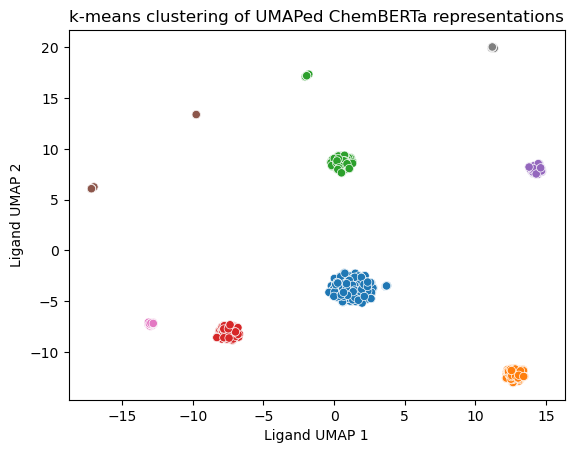

In [10]:
# Dimensionality reduction on ESM2 and ChemBERTa representations
n_clusters = 8
ligand_umap_df = ligand_umap(unique_smiles_df, embeddings_df, dimensions=3, plotting=False, seed=17)

# k-means clustering of ligands
ligand_umap_df = cluster_ligand(ligand_umap_df, n_clusters=n_clusters)

As described in milestone 2, our goal is to find a space where proteins are grouped according for their affinity to similar ligands. In the following, we use the ligand classes identified above by k-means clustering to assess whether ChemBERTa and ESM2 representations provide such **separability**.

We first visualize proteins by ligand group in a low-dimensional space using UMAP.

/home/ingster/anaconda3/envs/ada/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


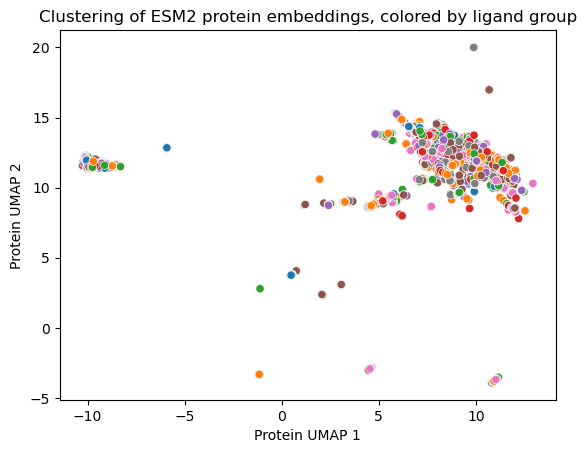

In [11]:
protein_ligand_matched = prot_umap(best_interactions_df, ligand_umap_df, dimensions=3, n_clusters=n_clusters)

It is quite striking that in this manifold, proteins are not grouped by ligand classes. Therefore, in the following, we retain all the dimensions of the ESM2 embeddings (no dimensionality reduction).

In [ ]:
X_prot = np.array([np.squeeze(x) for x in protein_ligand_matched['ESM2 Embedding']])
y = protein_ligand_matched['Ligand class']

# Cross-validation
cv = 5
knn_gscv = train_knn(X_prot, y, cv=cv);
svm_clf = train_svm(X_prot, y, cv=cv);
ll_gscv = train_logistic(X_prot, y, cv=cv);
mlp_clf = train_mlp(X_prot, y, num_layers=2, cv=cv);

Even the high-complexity models (MLP) struggle to identify a boundary in the ESM2 protein space based on the ligand classes. In the following section, we explore potential reasons for this.